***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.3)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "6" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  6
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_2_3')

FOLDER CREATED =  ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 8)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5247 - prediction_coarse_accuracy: 0.4589 - prediction_medium_accuracy: 0.2060 - prediction_fine_accuracy: 0.0083
  • Coarse Accuracy = 45.89% | Val_Accuracy = 50.25% | LossWeight = 0.36 
  • Medium Accuracy = 20.60% | Val_Accuracy = 26.94% | LossWeight = 0.48 
  • Fine   Accuracy = 0.83% | Val_Accuracy = 1.03% | LossWeight = 0.16 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.01030, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 64s 70ms/step - loss: 0.5247 - prediction_coarse_accuracy: 0.4589 - prediction_medium_accuracy: 0.2060 - prediction_fine_accuracy: 0.0083 - val_loss: 0.4605 - val_prediction_coarse_accuracy: 0.5025 - val_prediction_medium_accuracy: 0.2694 - val_prediction_fine_accuracy: 0.0103 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3935 - prediction_coarse_accuracy

781/781 [==============================] - 82s 106ms/step - loss: 0.2419 - prediction_coarse_accuracy: 0.8188 - prediction_medium_accuracy: 0.7178 - prediction_fine_accuracy: 0.0100 - val_loss: 0.2252 - val_prediction_coarse_accuracy: 0.8029 - val_prediction_medium_accuracy: 0.6843 - val_prediction_fine_accuracy: 0.0100 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.2350 - prediction_coarse_accuracy: 0.8306 - prediction_medium_accuracy: 0.7366 - prediction_fine_accuracy: 0.0144
  • Coarse Accuracy = 83.06% | Val_Accuracy = 79.83% | LossWeight = 0.27 
  • Medium Accuracy = 73.66% | Val_Accuracy = 67.39% | LossWeight = 0.37 
  • Fine   Accuracy = 1.44% | Val_Accuracy = 2.47% | LossWeight = 0.36 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.03430
781/781 [==============================] - 78s 100ms/step - loss: 0.2350 - prediction_coarse_accuracy: 0.8306 - prediction_medium_accuracy: 0.7366 - prediction_fine_accuracy: 0.0144 - val_

781/781 [==============================] - 54s 70ms/step - loss: 0.1730 - prediction_coarse_accuracy: 0.9105 - prediction_medium_accuracy: 0.8648 - prediction_fine_accuracy: 0.1830 - val_loss: 0.1930 - val_prediction_coarse_accuracy: 0.8297 - val_prediction_medium_accuracy: 0.7279 - val_prediction_fine_accuracy: 0.1671 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1685 - prediction_coarse_accuracy: 0.9140 - prediction_medium_accuracy: 0.8746 - prediction_fine_accuracy: 0.2008
  • Coarse Accuracy = 91.40% | Val_Accuracy = 82.83% | LossWeight = 0.22 
  • Medium Accuracy = 87.46% | Val_Accuracy = 72.03% | LossWeight = 0.29 
  • Fine   Accuracy = 20.08% | Val_Accuracy = 17.04% | LossWeight = 0.48 

Epoch 19: val_prediction_fine_accuracy improved from 0.16710 to 0.17040, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 54s 70ms/step - loss: 0.1685 - prediction_coarse_acc

781/781 [==============================] - 90s 116ms/step - loss: 0.1422 - prediction_coarse_accuracy: 0.9384 - prediction_medium_accuracy: 0.9163 - prediction_fine_accuracy: 0.2638 - val_loss: 0.1752 - val_prediction_coarse_accuracy: 0.8442 - val_prediction_medium_accuracy: 0.7445 - val_prediction_fine_accuracy: 0.2304 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1413 - prediction_coarse_accuracy: 0.9377 - prediction_medium_accuracy: 0.9174 - prediction_fine_accuracy: 0.2734
  • Coarse Accuracy = 93.77% | Val_Accuracy = 84.12% | LossWeight = 0.20 
  • Medium Accuracy = 91.74% | Val_Accuracy = 74.09% | LossWeight = 0.24 
  • Fine   Accuracy = 27.34% | Val_Accuracy = 22.95% | LossWeight = 0.55 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.23040
781/781 [==============================] - 82s 105ms/step - loss: 0.1413 - prediction_coarse_accuracy: 0.9377 - prediction_medium_accuracy: 0.9174 - prediction_fine_accuracy: 0.2734 

781/781 [==============================] - 86s 110ms/step - loss: 0.1307 - prediction_coarse_accuracy: 0.9487 - prediction_medium_accuracy: 0.9326 - prediction_fine_accuracy: 0.3329 - val_loss: 0.1661 - val_prediction_coarse_accuracy: 0.8490 - val_prediction_medium_accuracy: 0.7534 - val_prediction_fine_accuracy: 0.2826 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1298 - prediction_coarse_accuracy: 0.9489 - prediction_medium_accuracy: 0.9328 - prediction_fine_accuracy: 0.3371
  • Coarse Accuracy = 94.89% | Val_Accuracy = 84.88% | LossWeight = 0.19 
  • Medium Accuracy = 93.28% | Val_Accuracy = 75.41% | LossWeight = 0.23 
  • Fine   Accuracy = 33.71% | Val_Accuracy = 28.54% | LossWeight = 0.58 

Epoch 37: val_prediction_fine_accuracy improved from 0.28260 to 0.28540, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 79s 101ms/step - loss: 0.1298 - prediction_coarse_a

781/781 [==============================] - 54s 69ms/step - loss: 0.1228 - prediction_coarse_accuracy: 0.9542 - prediction_medium_accuracy: 0.9403 - prediction_fine_accuracy: 0.3886 - val_loss: 0.1602 - val_prediction_coarse_accuracy: 0.8514 - val_prediction_medium_accuracy: 0.7579 - val_prediction_fine_accuracy: 0.3214 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.1218 - prediction_coarse_accuracy: 0.9540 - prediction_medium_accuracy: 0.9424 - prediction_fine_accuracy: 0.3905
  • Coarse Accuracy = 95.40% | Val_Accuracy = 85.01% | LossWeight = 0.19 
  • Medium Accuracy = 94.24% | Val_Accuracy = 76.11% | LossWeight = 0.22 
  • Fine   Accuracy = 39.05% | Val_Accuracy = 32.56% | LossWeight = 0.59 

Epoch 46: val_prediction_fine_accuracy improved from 0.32140 to 0.32560, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 54s 69ms/step - loss: 0.1218 - prediction_coarse_acc

781/781 [==============================] - 54s 69ms/step - loss: 0.1199 - prediction_coarse_accuracy: 0.9557 - prediction_medium_accuracy: 0.9438 - prediction_fine_accuracy: 0.4256 - val_loss: 0.1576 - val_prediction_coarse_accuracy: 0.8540 - val_prediction_medium_accuracy: 0.7622 - val_prediction_fine_accuracy: 0.3541 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.1190 - prediction_coarse_accuracy: 0.9563 - prediction_medium_accuracy: 0.9439 - prediction_fine_accuracy: 0.4261
  • Coarse Accuracy = 95.63% | Val_Accuracy = 85.46% | LossWeight = 0.19 
  • Medium Accuracy = 94.39% | Val_Accuracy = 76.49% | LossWeight = 0.22 
  • Fine   Accuracy = 42.61% | Val_Accuracy = 35.10% | LossWeight = 0.59 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.35410
781/781 [==============================] - 54s 69ms/step - loss: 0.1190 - prediction_coarse_accuracy: 0.9563 - prediction_medium_accuracy: 0.9439 - prediction_fine_accuracy: 0.4261 - 

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.1180 - prediction_coarse_accuracy: 0.9557 - prediction_medium_accuracy: 0.9435 - prediction_fine_accuracy: 0.4498
  • Coarse Accuracy = 95.57% | Val_Accuracy = 85.74% | LossWeight = 0.20 
  • Medium Accuracy = 94.35% | Val_Accuracy = 76.60% | LossWeight = 0.23 
  • Fine   Accuracy = 44.98% | Val_Accuracy = 36.85% | LossWeight = 0.57 

Epoch 64: val_prediction_fine_accuracy improved from 0.36530 to 0.36850, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 63s 81ms/step - loss: 0.1180 - prediction_coarse_accuracy: 0.9557 - prediction_medium_accuracy: 0.9435 - prediction_fine_accuracy: 0.4498 - val_loss: 0.1554 - val_prediction_coarse_accuracy: 0.8574 - val_prediction_medium_accuracy: 0.7660 - val_prediction_fine_accuracy: 0.3685 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.1167 - prediction_coa

Epoch 82/100
781/781 [==============================] - ETA: 0s - loss: 0.1149 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9472 - prediction_fine_accuracy: 0.4710
  • Coarse Accuracy = 95.80% | Val_Accuracy = 85.53% | LossWeight = 0.20 
  • Medium Accuracy = 94.72% | Val_Accuracy = 76.80% | LossWeight = 0.22 
  • Fine   Accuracy = 47.10% | Val_Accuracy = 38.11% | LossWeight = 0.58 

Epoch 82: val_prediction_fine_accuracy did not improve from 0.38180
781/781 [==============================] - 73s 93ms/step - loss: 0.1149 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9472 - prediction_fine_accuracy: 0.4710 - val_loss: 0.1526 - val_prediction_coarse_accuracy: 0.8553 - val_prediction_medium_accuracy: 0.7680 - val_prediction_fine_accuracy: 0.3811 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.1149 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.

781/781 [==============================] - 49s 63ms/step - loss: 0.1138 - prediction_coarse_accuracy: 0.9591 - prediction_medium_accuracy: 0.9494 - prediction_fine_accuracy: 0.4762 - val_loss: 0.1520 - val_prediction_coarse_accuracy: 0.8586 - val_prediction_medium_accuracy: 0.7699 - val_prediction_fine_accuracy: 0.3880 - lr: 9.8884e-06


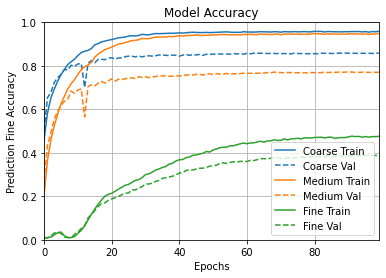

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

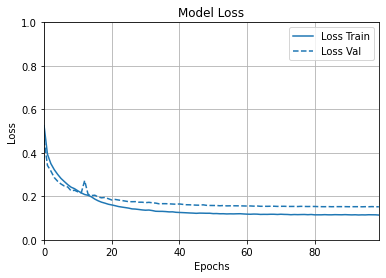

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 18ms/step - loss: 0.3570 - prediction_coarse_loss: 0.1102 - prediction_medium_loss: 0.1760 - prediction_fine_loss: 0.5072 - prediction_coarse_accuracy: 0.8586 - prediction_medium_accuracy: 0.7699 - prediction_fine_accuracy: 0.3880
1. loss ==> 0.357031911611557
2. prediction_coarse_loss ==> 0.11023182421922684
3. prediction_medium_loss ==> 0.175985649228096
4. prediction_fine_loss ==> 0.5071823596954346
5. prediction_coarse_accuracy ==> 0.8586000204086304
6. prediction_medium_accuracy ==> 0.7699000239372253
7. prediction_fine_accuracy ==> 0.3880000114440918
313/313 [==============================] - 5s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

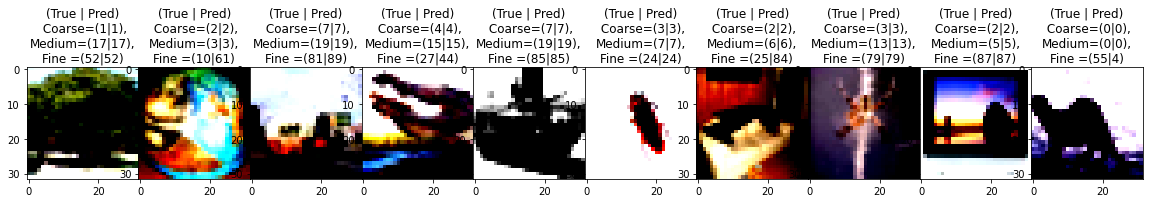

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 729   14   17   30  177   12    9   12]
 [  10 1366   28   24   44   22    2    4]
 [  20   23 1345   28   27   12   14   31]
 [  21   36   37  786  104    4    4    8]
 [ 101   24   44  114 2167   12   11   27]
 [   9   26   26   11   31  870    0   27]
 [   6   11   14   12   34    0  419    4]
 [   7    0   23   11   26   29    0  904]]

  • MEDIUM LEVEL 
[[326  32   1   1   1   1   1   4  19   3   4  14  22  12   4  22  29   0
    1   3]
 [ 38 351   8   5   6   3   3   5   4   3   3   6   4  10   6  22  14   1
    4   4]
 [  0   6 449   5  11   3   1  11   1   1   2   0   0   5   0   3   1   0
    1   0]
 [  1   2   5 401   8  37   8   7   5   2   0   1   1   6   5   1   0   0
    3   7]
 [  3   4  22   5 422   6   1   5   5   0   1   3   1   7   0   4   7   3
    0   1]
 [  1  11   0  27   8 381  25   1   1   5   3   1   3   5   9   3   1   2
    7   6]
 [  2   7   3   9   0  26 420   4   1   4   1   0   0   6   3   4   1   1
    6   2]


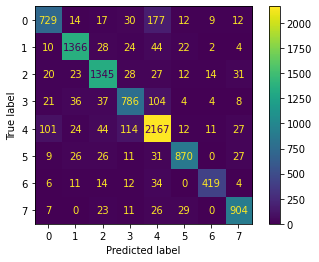

              precision    recall  f1-score   support

           0    0.80731   0.72900   0.76616      1000
           1    0.91067   0.91067   0.91067      1500
           2    0.87679   0.89667   0.88662      1500
           3    0.77362   0.78600   0.77976      1000
           4    0.83027   0.86680   0.84814      2500
           5    0.90531   0.87000   0.88730      1000
           6    0.91285   0.83800   0.87383       500
           7    0.88889   0.90400   0.89638      1000

    accuracy                        0.85860     10000
   macro avg    0.86321   0.85014   0.85611     10000
weighted avg    0.85884   0.85860   0.85828     10000


  • MEDIUM LEVEL 


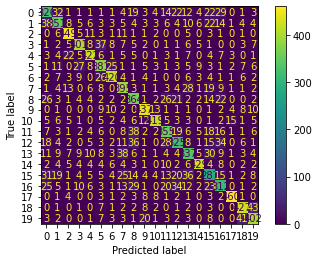

              precision    recall  f1-score   support

           0    0.65200   0.65200   0.65200       500
           1    0.73895   0.70200   0.72000       500
           2    0.85038   0.89800   0.87354       500
           3    0.82172   0.80200   0.81174       500
           4    0.84232   0.84400   0.84316       500
           5    0.72296   0.76200   0.74197       500
           6    0.85020   0.84000   0.84507       500
           7    0.72344   0.79000   0.75526       500
           8    0.67283   0.72800   0.69933       500
           9    0.84854   0.87400   0.86108       500
          10    0.89722   0.83800   0.86660       500
          11    0.71862   0.71000   0.71429       500
          12    0.69296   0.65000   0.67079       500
          13    0.67944   0.67400   0.67671       500
          14    0.90506   0.85800   0.88090       500
          15    0.59175   0.57400   0.58274       500
          16    0.64463   0.62400   0.63415       500
          17    0.93878   0

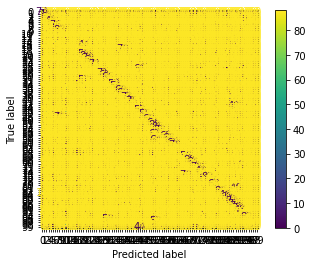

              precision    recall  f1-score   support

           0    0.72642   0.77000   0.74757       100
           1    0.47333   0.71000   0.56800       100
           2    0.28700   0.64000   0.39628       100
           3    0.00000   0.00000   0.00000       100
           4    0.22273   0.49000   0.30625       100
           5    0.00000   0.00000   0.00000       100
           6    0.33188   0.76000   0.46201       100
           7    0.58929   0.33000   0.42308       100
           8    0.47568   0.88000   0.61754       100
           9    0.00000   0.00000   0.00000       100
          10    0.18343   0.31000   0.23048       100
          11    0.25000   0.43000   0.31618       100
          12    0.00000   0.00000   0.00000       100
          13    0.41892   0.31000   0.35632       100
          14    0.00000   0.00000   0.00000       100
          15    0.21429   0.21000   0.21212       100
          16    0.00000   0.00000   0.00000       100
          17    0.24000   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.671475 
Hierarchical Recall = 0.6820999999999998 
Hierarchical F1-Score = 0.6756765873015873 
Consistency =  0.9269 
Exact Match =  0.3786


# Training Again

In [22]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1531 - prediction_coarse_accuracy: 0.9037 - prediction_medium_accuracy: 0.8601 - prediction_fine_accuracy: 0.3844
  • Coarse Accuracy = 90.37% | Val_Accuracy = 81.76% | LossWeight = 0.26 
  • Medium Accuracy = 86.01% | Val_Accuracy = 71.22% | LossWeight = 0.34 
  • Fine   Accuracy = 38.44% | Val_Accuracy = 32.36% | LossWeight = 0.39 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.38900
781/781 [==============================] - 52s 66ms/step - loss: 0.1531 - prediction_coarse_accuracy: 0.9037 - prediction_medium_accuracy: 0.8601 - prediction_fine_accuracy: 0.3844 - val_loss: 0.1791 - val_prediction_coarse_accuracy: 0.8176 - val_prediction_medium_accuracy: 0.7122 - val_prediction_fine_accuracy: 0.3236 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1564 - prediction_coarse_accuracy: 0.9098 - prediction_medium_accuracy: 0.8700 - prediction_fine_accuracy: 0.3908
  

781/781 [==============================] - 50s 64ms/step - loss: 0.1278 - prediction_coarse_accuracy: 0.9388 - prediction_medium_accuracy: 0.9159 - prediction_fine_accuracy: 0.4910 - val_loss: 0.1672 - val_prediction_coarse_accuracy: 0.8383 - val_prediction_medium_accuracy: 0.7334 - val_prediction_fine_accuracy: 0.4116 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1277 - prediction_coarse_accuracy: 0.9372 - prediction_medium_accuracy: 0.9144 - prediction_fine_accuracy: 0.5033
  • Coarse Accuracy = 93.72% | Val_Accuracy = 83.43% | LossWeight = 0.25 
  • Medium Accuracy = 91.44% | Val_Accuracy = 73.53% | LossWeight = 0.30 
  • Fine   Accuracy = 50.33% | Val_Accuracy = 42.54% | LossWeight = 0.45 

Epoch 10: val_prediction_fine_accuracy improved from 0.41160 to 0.42540, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 51s 65ms/step - loss: 0.1277 - prediction_coarse_accurac

781/781 [==============================] - 85s 109ms/step - loss: 0.1267 - prediction_coarse_accuracy: 0.9349 - prediction_medium_accuracy: 0.9115 - prediction_fine_accuracy: 0.5555 - val_loss: 0.1600 - val_prediction_coarse_accuracy: 0.8399 - val_prediction_medium_accuracy: 0.7431 - val_prediction_fine_accuracy: 0.4670 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1199 - prediction_coarse_accuracy: 0.9458 - prediction_medium_accuracy: 0.9260 - prediction_fine_accuracy: 0.5766
  • Coarse Accuracy = 94.58% | Val_Accuracy = 83.88% | LossWeight = 0.25 
  • Medium Accuracy = 92.60% | Val_Accuracy = 74.64% | LossWeight = 0.30 
  • Fine   Accuracy = 57.66% | Val_Accuracy = 47.67% | LossWeight = 0.45 

Epoch 19: val_prediction_fine_accuracy improved from 0.47550 to 0.47670, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 80s 102ms/step - loss: 0.1199 - prediction_coarse_a

781/781 [==============================] - 85s 109ms/step - loss: 0.1065 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.9419 - prediction_fine_accuracy: 0.6580 - val_loss: 0.1496 - val_prediction_coarse_accuracy: 0.8489 - val_prediction_medium_accuracy: 0.7576 - val_prediction_fine_accuracy: 0.5227 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1065 - prediction_coarse_accuracy: 0.9545 - prediction_medium_accuracy: 0.9413 - prediction_fine_accuracy: 0.6658
  • Coarse Accuracy = 95.45% | Val_Accuracy = 85.18% | LossWeight = 0.26 
  • Medium Accuracy = 94.13% | Val_Accuracy = 76.32% | LossWeight = 0.30 
  • Fine   Accuracy = 66.58% | Val_Accuracy = 52.68% | LossWeight = 0.44 

Epoch 28: val_prediction_fine_accuracy improved from 0.52270 to 0.52680, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 85s 109ms/step - loss: 0.1065 - prediction_coarse_a

781/781 [==============================] - 84s 108ms/step - loss: 0.1022 - prediction_coarse_accuracy: 0.9559 - prediction_medium_accuracy: 0.9449 - prediction_fine_accuracy: 0.7045 - val_loss: 0.1453 - val_prediction_coarse_accuracy: 0.8527 - val_prediction_medium_accuracy: 0.7657 - val_prediction_fine_accuracy: 0.5480 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1018 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.7122
  • Coarse Accuracy = 95.86% | Val_Accuracy = 85.44% | LossWeight = 0.27 
  • Medium Accuracy = 94.76% | Val_Accuracy = 76.22% | LossWeight = 0.30 
  • Fine   Accuracy = 71.22% | Val_Accuracy = 54.72% | LossWeight = 0.43 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.54800
781/781 [==============================] - 84s 107ms/step - loss: 0.1018 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.7122 

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.1002 - prediction_coarse_accuracy: 0.9588 - prediction_medium_accuracy: 0.9479 - prediction_fine_accuracy: 0.7371
  • Coarse Accuracy = 95.88% | Val_Accuracy = 85.75% | LossWeight = 0.28 
  • Medium Accuracy = 94.79% | Val_Accuracy = 76.98% | LossWeight = 0.31 
  • Fine   Accuracy = 73.71% | Val_Accuracy = 55.57% | LossWeight = 0.41 

Epoch 46: val_prediction_fine_accuracy improved from 0.55540 to 0.55570, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 75s 96ms/step - loss: 0.1002 - prediction_coarse_accuracy: 0.9588 - prediction_medium_accuracy: 0.9479 - prediction_fine_accuracy: 0.7371 - val_loss: 0.1442 - val_prediction_coarse_accuracy: 0.8575 - val_prediction_medium_accuracy: 0.7698 - val_prediction_fine_accuracy: 0.5557 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0987 - prediction_coa

Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0993 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9486 - prediction_fine_accuracy: 0.7549
  • Coarse Accuracy = 95.94% | Val_Accuracy = 85.74% | LossWeight = 0.28 
  • Medium Accuracy = 94.86% | Val_Accuracy = 76.95% | LossWeight = 0.32 
  • Fine   Accuracy = 75.49% | Val_Accuracy = 56.02% | LossWeight = 0.40 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.56240
781/781 [==============================] - 73s 93ms/step - loss: 0.0993 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9486 - prediction_fine_accuracy: 0.7549 - val_loss: 0.1434 - val_prediction_coarse_accuracy: 0.8574 - val_prediction_medium_accuracy: 0.7695 - val_prediction_fine_accuracy: 0.5602 - lr: 9.9440e-05
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.0983 - prediction_coarse_accuracy: 0.9612 - prediction_medium_accuracy: 0.9506 - prediction_fine_accuracy: 0.

781/781 [==============================] - 85s 108ms/step - loss: 0.0963 - prediction_coarse_accuracy: 0.9624 - prediction_medium_accuracy: 0.9533 - prediction_fine_accuracy: 0.7723 - val_loss: 0.1421 - val_prediction_coarse_accuracy: 0.8595 - val_prediction_medium_accuracy: 0.7724 - val_prediction_fine_accuracy: 0.5650 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0971 - prediction_coarse_accuracy: 0.9603 - prediction_medium_accuracy: 0.9498 - prediction_fine_accuracy: 0.7710
  • Coarse Accuracy = 96.03% | Val_Accuracy = 85.95% | LossWeight = 0.29 
  • Medium Accuracy = 94.98% | Val_Accuracy = 77.16% | LossWeight = 0.33 
  • Fine   Accuracy = 77.10% | Val_Accuracy = 56.70% | LossWeight = 0.39 

Epoch 65: val_prediction_fine_accuracy improved from 0.56500 to 0.56700, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 73s 93ms/step - loss: 0.0971 - prediction_coarse_ac

Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0962 - prediction_coarse_accuracy: 0.9625 - prediction_medium_accuracy: 0.9518 - prediction_fine_accuracy: 0.7758
  • Coarse Accuracy = 96.25% | Val_Accuracy = 85.94% | LossWeight = 0.28 
  • Medium Accuracy = 95.18% | Val_Accuracy = 77.41% | LossWeight = 0.33 
  • Fine   Accuracy = 77.58% | Val_Accuracy = 56.96% | LossWeight = 0.39 

Epoch 74: val_prediction_fine_accuracy improved from 0.56910 to 0.56960, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss\epoch-best.h5
781/781 [==============================] - 62s 79ms/step - loss: 0.0962 - prediction_coarse_accuracy: 0.9625 - prediction_medium_accuracy: 0.9518 - prediction_fine_accuracy: 0.7758 - val_loss: 0.1424 - val_prediction_coarse_accuracy: 0.8594 - val_prediction_medium_accuracy: 0.7741 - val_prediction_fine_accuracy: 0.5696 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0957 - prediction_coa

781/781 [==============================] - 61s 78ms/step - loss: 0.0967 - prediction_coarse_accuracy: 0.9624 - prediction_medium_accuracy: 0.9525 - prediction_fine_accuracy: 0.7824 - val_loss: 0.1416 - val_prediction_coarse_accuracy: 0.8610 - val_prediction_medium_accuracy: 0.7775 - val_prediction_fine_accuracy: 0.5712 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0958 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.7860
  • Coarse Accuracy = 96.11% | Val_Accuracy = 85.98% | LossWeight = 0.29 
  • Medium Accuracy = 95.13% | Val_Accuracy = 77.55% | LossWeight = 0.33 
  • Fine   Accuracy = 78.60% | Val_Accuracy = 57.18% | LossWeight = 0.38 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.57180
781/781 [==============================] - 64s 83ms/step - loss: 0.0958 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9513 - prediction_fine_accuracy: 0.7860 - 

In [23]:
history_dict = history.history

(0.0, 1.0)

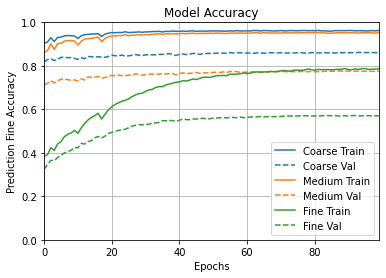

In [24]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

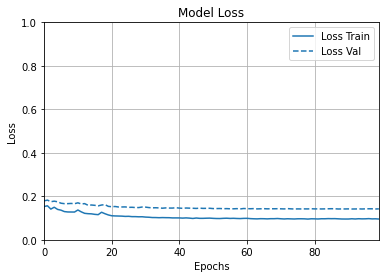

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [26]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 9s 22ms/step - loss: 0.2240 - prediction_coarse_loss: 0.1072 - prediction_medium_loss: 0.1710 - prediction_fine_loss: 0.3546 - prediction_coarse_accuracy: 0.8603 - prediction_medium_accuracy: 0.7748 - prediction_fine_accuracy: 0.5701
1. loss ==> 0.22398629784584045
2. prediction_coarse_loss ==> 0.10718492418527603
3. prediction_medium_loss ==> 0.1710231751203537
4. prediction_fine_loss ==> 0.3545904755592346
5. prediction_coarse_accuracy ==> 0.8603000044822693
6. prediction_medium_accuracy ==> 0.7748000025749207
7. prediction_fine_accuracy ==> 0.5701000094413757
313/313 [==============================] - 5s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

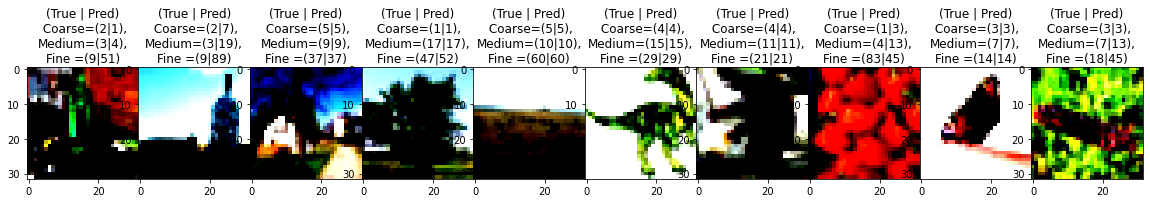

In [27]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 691   14   21   33  206   12   12   11]
 [   5 1375   29   30   37   18    1    5]
 [  12   28 1353   30   20   11   14   32]
 [  13   34   38  789  108    3    3   12]
 [  99   15   48  101 2194    8   13   22]
 [   7   22   28    9   29  875    0   30]
 [   4   11   17   13   39    1  413    2]
 [   9    0   25   13   19   21    0  913]]

  • MEDIUM LEVEL 
[[307  27   1   1   1   6   2   7  16   6   4  16  21  11   6  32  30   2
    3   1]
 [ 31 361   7   4   5   6   3   7   3   2   3   8   5   7   9  24   7   1
    4   3]
 [  0   4 446   5  12   3   1  11   0   1   3   1   1   7   0   1   2   0
    1   1]
 [  2   1   4 406  14  36   4   3   0   1   0   2   1   9   6   2   0   0
    2   7]
 [  0   2  21   7 421   5   2   7   5   2   0   4   2  10   1   3   5   2
    1   0]
 [  3   7   1  31   6 378  26   1   1   5   2   0   1   9   8   3   1   2
    3  12]
 [  0   3   3   9   0  22 431   3   1   2   2   0   0   6   4   2   2   1
    8   1]


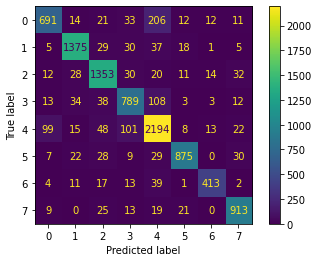

              precision    recall  f1-score   support

           0    0.82262   0.69100   0.75109      1000
           1    0.91728   0.91667   0.91697      1500
           2    0.86786   0.90200   0.88460      1500
           3    0.77505   0.78900   0.78196      1000
           4    0.82730   0.87760   0.85171      2500
           5    0.92202   0.87500   0.89790      1000
           6    0.90570   0.82600   0.86402       500
           7    0.88900   0.91300   0.90084      1000

    accuracy                        0.86030     10000
   macro avg    0.86585   0.84878   0.85614     10000
weighted avg    0.86075   0.86030   0.85954     10000


  • MEDIUM LEVEL 


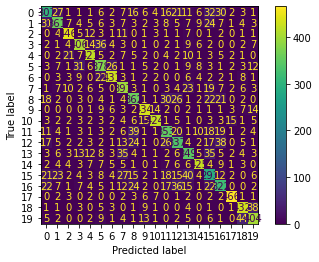

              precision    recall  f1-score   support

           0    0.68680   0.61400   0.64836       500
           1    0.76809   0.72200   0.74433       500
           2    0.87280   0.89200   0.88229       500
           3    0.80237   0.81200   0.80716       500
           4    0.83865   0.84200   0.84032       500
           5    0.72137   0.75600   0.73828       500
           6    0.86546   0.86200   0.86373       500
           7    0.72051   0.79400   0.75547       500
           8    0.70841   0.72400   0.71612       500
           9    0.85941   0.86800   0.86368       500
          10    0.90987   0.84800   0.87785       500
          11    0.72041   0.70600   0.71313       500
          12    0.68916   0.67400   0.68150       500
          13    0.68164   0.69800   0.68972       500
          14    0.87629   0.85000   0.86294       500
          15    0.57451   0.58600   0.58020       500
          16    0.66119   0.64400   0.65248       500
          17    0.93014   0

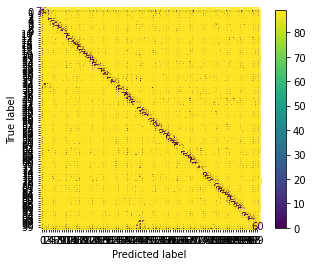

              precision    recall  f1-score   support

           0    0.90361   0.75000   0.81967       100
           1    0.84211   0.64000   0.72727       100
           2    0.29851   0.60000   0.39867       100
           3    0.44186   0.38000   0.40860       100
           4    0.40789   0.31000   0.35227       100
           5    0.63095   0.53000   0.57609       100
           6    0.77215   0.61000   0.68156       100
           7    0.73034   0.65000   0.68783       100
           8    0.82979   0.78000   0.80412       100
           9    0.73333   0.66000   0.69474       100
          10    0.40909   0.45000   0.42857       100
          11    0.27778   0.25000   0.26316       100
          12    0.50345   0.73000   0.59592       100
          13    0.52830   0.56000   0.54369       100
          14    0.26540   0.56000   0.36013       100
          15    0.56471   0.48000   0.51892       100
          16    0.38400   0.48000   0.42667       100
          17    0.85882   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7333533333333333 
Hierarchical Recall = 0.7473 
Hierarchical F1-Score = 0.7387896825396825 
Consistency =  0.909 
Exact Match =  0.5579
